# Tutorial on `edu-convokit` for the NCTE dataset

Welcome to the tutorial on `edu-convokit` for the [NCTE dataset](https://github.com/ddemszky/classroom-transcript-analysis). This tutorial will walk you through the process of using `edu-convokit` to pre-process, annotate and analyze the NCTE dataset.

If you are looking for a tutorial on the individual components of `edu-convokit`, please refer to the following tutorials to get started:
- [Text Pre-processing Colab](https://colab.research.google.com/drive/1a-EwYwkNYHSNcNThNTXe6DNpsis0bpQK)
- [Annotation Colab](https://colab.research.google.com/drive/1rBwEctFtmQowZHxralH2OGT5uV0zRIQw)
- [Analysis Colab](https://colab.research.google.com/drive/1xfrq5Ka3FZH7t9l87u4sa_oMlmMvuTfe)

This tutorial will use all of the components!

## Installation

Let's start by installing `edu-convokit` and importing the necessary modules.


In [ ]:
!pip install edu-convokit

  Cloning https://github.com/rosewang2008/edu-convokit.git to /tmp/pip-req-build-ncsfguml
  Running command git clone --filter=blob:none --quiet https://github.com/rosewang2008/edu-convokit.git /tmp/pip-req-build-ncsfguml
  Resolved https://github.com/rosewang2008/edu-convokit.git to commit 5c1128c8f94d7574bc61cc56f29ce64bdca4ae30
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.0 MB/s eta 0:00:00
  Created wheel for edu-convokit: filename=edu_convokit-0.0.1-py3-none-any.whl size=24909 sha256=257e42119604caf33f42981c96e1407bdb7733bc8082e870a022def70e9310c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vp1s8qol/wheels/29/43/ec/d2472df0eb2af8f1e7d67d0710a4b3eb93fe983b15f8d7b841
  Created wh

In [ ]:
from edu_convokit.preprocessors import TextPreprocessor
from edu_convokit.annotation import Annotator
from edu_convokit.analyzers import (
    QualitativeAnalyzer,
    QuantitativeAnalyzer,
    LexicalAnalyzer,
    TemporalAnalyzer,
    GPTConversationAnalyzer
)
# For helping us load data
from edu_convokit import utils

import os
import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 📑 Data

Let's download the dataset under `raw_data/`.
Note we're only download a subsample of the NCTE dataset for this tutorial; this cuts down the annotation time.
If you would like to annotate the entire dataset, feel free to upload the entire dataset to this Colab!

In [ ]:
# We will put the data here:
DATA_DIR = "raw_data"
!mkdir -p $DATA_DIR

# We will put the annotated data here:
ANNOTATIONS_DIR = "annotations"
!mkdir -p $ANNOTATIONS_DIR

# # Download the data
!wget "https://raw.githubusercontent.com/rosewang2008/edu-convokit/master/data/ncte.zip"

# # Unzip the data
!unzip -n -q ncte.zip -d $DATA_DIR

# Data directory is then raw_data/talkmoves
DATA_DIR = "raw_data/ncte"

--2023-12-30 10:54:18--  https://raw.githubusercontent.com/rosewang2008/edu-convokit/master/data/ncte.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346717 (339K) [application/zip]
Saving to: ‘ncte.zip’

ncte.zip            100%[===================>] 338.59K  --.-KB/s    in 0.03s   

2023-12-30 10:54:19 (9.57 MB/s) - ‘ncte.zip’ saved [346717/346717]



In [ ]:
# We'll set the important variables specific to this dataset. If you open one of the files, you'll see that the
# speaker and text columns are defined as:
TEXT_COLUMN = "text"
SPEAKER_COLUMN = "speaker"

# We will also define the annotation columns.
# For the purposes of this tutorial, we will only be using talktime, student_reasoning, and uptake.
TALK_TIME_COLUMN = "talktime"
STUDENT_REASONING_COLUMN = "student_reasoning"
UPTAKE_COLUMN = "uptake"

One thing that will be important is knowing how the teacher/tutor and student are represented in the dataset.
Let's load some examples and see how they are represented.

In [ ]:
files = os.listdir(DATA_DIR)
files = [os.path.join(DATA_DIR, f) for f in files if utils.is_valid_file_extension(f)]
df = utils.merge_dataframes_in_list(files)
print(df[SPEAKER_COLUMN].unique())
df.head()

['teacher' 'multiple students' 'student']


,text,speaker,talktime_words,math_density,uptake,student_reasoning,focusing_questions
0,"Okay. I think it’s working. Alright, so the ...",teacher,17,0,NaN,NaN,0.0
1,Yes.,multiple students,1,0,NaN,NaN,NaN
2,"Student M, you don’t have your homework?",teacher,7,0,NaN,NaN,0.0
3,No.,student,1,0,NaN,NaN,NaN
4,Did you hand it in?,teacher,5,0,NaN,NaN,0.0


There are two speakers: one is the teacher and the other is the student/multiple students.
Let's defined these variables as well.

In [ ]:
STUDENT_SPEAKER = ['student', 'multiple students']
TEACHER_SPEAKER = 'teacher'

## 📝 Text Pre-Processing and Annotation

Let's first preprocess and annotate the dataset with `edu-convokit`. The following section will:
- Read each file in the dataset and preprocess it using `edu-convokit`'s `Preprocessor`.
- Then, annotate the file using `edu-convokit`'s `Annotator` for talktime, student reasoning and uptake.
- Finally, save the annotated file under `data/annotated/`.

Let's get started!

In [ ]:
# Initialize the preprocessor and annotator
processor = TextPreprocessor()
annotator = Annotator()

# This takes about 7 minutes on Colab, CPU
# Though this time varies depending on bandwidth
for filename in tqdm.tqdm(os.listdir(DATA_DIR)):
    if utils.is_valid_file_extension(filename):
        df = utils.load_data(os.path.join(DATA_DIR, filename))

    # Preprocess the data. We're just going to merge the utterances of the same speaker together and directly update the dataframe.
    df = processor.merge_utterances_from_same_speaker(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        target_text_column=TEXT_COLUMN
    )

    # Now we're going to annotate the data.
    df = annotator.get_talktime(
        df=df,
        text_column=TEXT_COLUMN,
        output_column=TALK_TIME_COLUMN
    )

    df = annotator.get_student_reasoning(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        output_column=STUDENT_REASONING_COLUMN,
        # We just want to annotate the student utterances. So we're going to specify the speaker value as STUDENT_SPEAKER.
        speaker_value=STUDENT_SPEAKER
    )

    df = annotator.get_uptake(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        output_column=UPTAKE_COLUMN,
        # We want to annotate the teacher's uptake of the student's utterances.
        # So we're looking for instances where the student first speaks, then the teacher speaks.
        speaker1=STUDENT_SPEAKER,
        speaker2=TEACHER_SPEAKER
    )

    # And we're done! Let's now save the annotated data as a csv file.
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(os.path.join(ANNOTATIONS_DIR, filename), index=False)

  0%|          | 0/29 [00:00<?, ?it/s]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf


tokenizer_config.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

  3%|▎         | 1/29 [00:26<12:22, 26.51s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
  7%|▋         | 2/29 [00:35<07:16, 16.17s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
 10%|█         | 3/29 [00:48<06:25, 14.81s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
 14%|█▍        | 4/29 [01:04<06:17, 15.08s/it]WARNING:root:Note: This model was tr

## Analysis

Now that we have annotated the dataset, let's analyze it using `edu-convokit`'s `Analyzer`. We'll be doing the following:
- We'll use `QualitativeAnalyzer` to look at some examples of the talktime, student reasoning and uptake annotations.
- We'll use `QuantitativeAnalyzer` to look at the aggregate statistics of the talktime, student reasoning and uptake annotations.
- We'll use `LexicalAnalyzer` to compare the student and tutor's vocabulary.
- We'll use `TemporalAnalyzer` to look at the temporal trends of the talktime, student reasoning and uptake annotations.

Let's get started!!!

### 🔍 Qualitative Analysis

In [ ]:
# We're going to look at examples from the entire dataset.
qualitative_analyzer = QualitativeAnalyzer(data_dir=ANNOTATIONS_DIR)

# Examples of talktime. Will show random examples from the dataset.
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=TALK_TIME_COLUMN,
)

talktime: 17
>> teacher: Okay.  I think it’s working.  Alright, so the first thing – everyone got their homework back, correct?

talktime: 17
>> teacher: Okay.  That could be your problem.  Student [G], do you have a question?  Student N, sit up.

talktime: 17
>> student: A year has 52 weeks so 52 times 4 equals 52 times 2 plus 52 times 2.

talktime: 1
>> multiple students: Yes.

talktime: 1
>> student: No.

talktime: 1
>> student: Yes.

talktime: 7
>> teacher: Student M, you don’t have your homework?

talktime: 7
>> student: [Inaudible]. She just didn’t really – oh.

talktime: 7
>> student: 60 times 11; and 3 times 11.



In [ ]:
# Examples of student reasoning. Let's look at positive examples:
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=STUDENT_REASONING_COLUMN,
    feature_value=1.0,
)

student_reasoning: 1.0
>> student: You could – so 76 times 10 is double the final problem so you –

student_reasoning: 1.0
>> student: They all will add up to a whole.

student_reasoning: 1.0
>> student: Because I know that three-sixths is equivalent to one-half in fractions.



In [ ]:
# We can also look at negative examples:
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=STUDENT_REASONING_COLUMN,
    feature_value=0.0,
)

student_reasoning: 0.0
>> student: No.  This is Student D.D.; this is Student D.C.

student_reasoning: 0.0
>> student: Do you want me to go that way?

student_reasoning: 0.0
>> student: I did 63 times 10 equals 630 and then 63 to that equals [Inaudible] and then I got, I got 693.



In [ ]:
# Examples of uptake.
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=UPTAKE_COLUMN,
    # I want to look at positive examples of uptake (uptake = 1.0)
    feature_value=1.0,
    # ... and look at the previous student utterance (show_k_previous_lines = 1).
    # This is interesting because it will show us how the teacher is responding to the student's utterance.
    show_k_previous_lines=1,
)

uptake: 1.0
student: No.  This is Student D.D.; this is Student D.C.
>> teacher: Okay, give Student D.C. his.  And what are you on Student D?

uptake: 1.0
student: Can I leave my desk?
>> teacher: You may go get it.  Student A, can you please get Student N’s folder out of her desk, and Student J, can you please turn off a light.

uptake: 1.0
student: 63 times 10 is 630.
>> teacher: 630.  Good.  Um, Student H, what’s 60 times 11?



### 📊 Quantitative Analysis

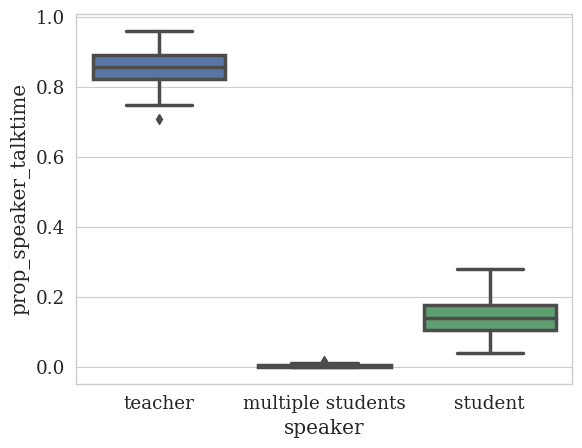

talktime

Proportion statistics
                   count      mean       std       min       25%       50%       75%       max
speaker                                                                                       
multiple students   29.0  0.003755  0.004297  0.000127  0.000892  0.002291  0.004942  0.017520
student             29.0  0.145835  0.054895  0.040153  0.105824  0.139083  0.176111  0.279475
teacher             29.0  0.850410  0.056019  0.709941  0.821598  0.858346  0.890292  0.959623


<Figure size 640x480 with 0 Axes>

In [ ]:
quantitative_analyzer = QuantitativeAnalyzer(data_dir=ANNOTATIONS_DIR)

# Let's plot the talk time ratio between the speakers.
quantitative_analyzer.plot_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # Proportion of talk time for each speaker.
    value_as="prop"
)

# We can also print the statistics:
quantitative_analyzer.print_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # Proportion of talk time for each speaker.
    value_as="prop"
)

/usr/local/lib/python3.10/dist-packages/edu_convokit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


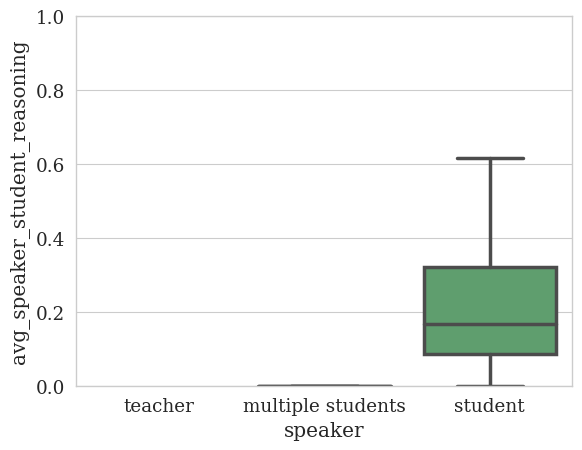

student_reasoning

Average statistics
                   count      mean       std  min       25%       50%       75%       max
speaker                                                                                  
multiple students    1.0  0.000000       NaN  0.0  0.000000  0.000000  0.000000  0.000000
student             29.0  0.208633  0.163928  0.0  0.085106  0.166667  0.321429  0.615385
teacher              0.0       NaN       NaN  NaN       NaN       NaN       NaN       NaN




/usr/local/lib/python3.10/dist-packages/edu_convokit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


<Figure size 640x480 with 0 Axes>

In [ ]:
# What about the student reasoning? How often does the student use reasoning?
quantitative_analyzer.plot_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # We change this to "avg" because we're now looking at within-speaker statistics.
    value_as="avg",
    # We can set the y-axis limits to [0, 1] because the student reasoning column is a binary column.
    yrange=(0, 1)
)

# We can also print the statistics:
quantitative_analyzer.print_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg"
)

Note, the tutor has no `student_reasoning` because we did not annotate the tutor's utterances for student reasoning.
We can easily remove the tutor from the plot by dropping na values:

/usr/local/lib/python3.10/dist-packages/edu_convokit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,
/usr/local/lib/python3.10/dist-packages/edu_convokit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


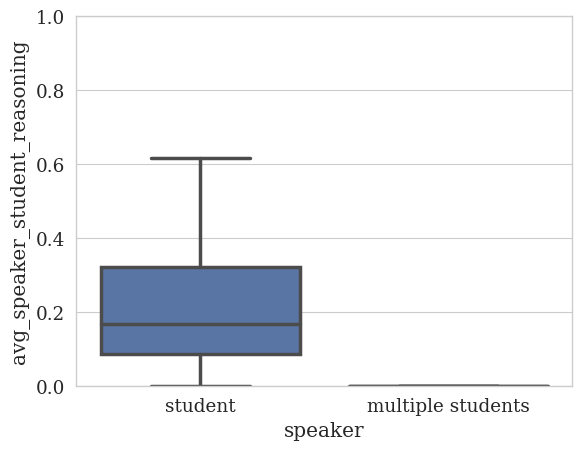

<Figure size 640x480 with 0 Axes>

In [ ]:
quantitative_analyzer.plot_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    yrange=(0, 1),
    dropna=True
)

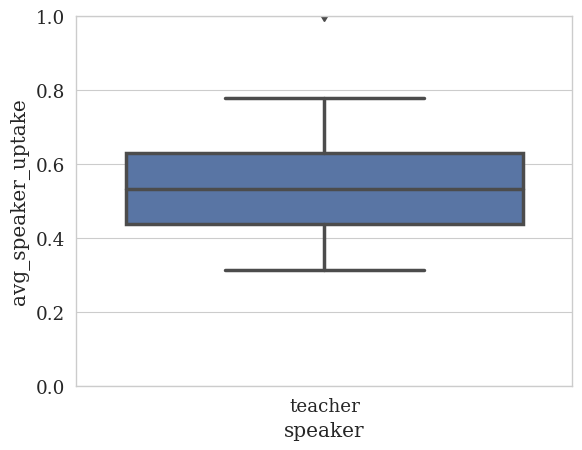

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finally, let's look at the tutor's uptake of the student's utterances.
quantitative_analyzer.plot_statistics(
    feature_column=UPTAKE_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    yrange=(0, 1),
    dropna=True
)

## 💬 Lexical Analysis

In [ ]:
lexical_analyzer = LexicalAnalyzer(data_dir=ANNOTATIONS_DIR)

# Let's look at the most common words per speaker in the dataset.
lexical_analyzer.print_word_frequency(
    text_column=TEXT_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # We want to look at the top 10 words per speaker.
    topk=10,
    # Let's also format the text (e.g., remove punctuation, lowercase the text, etc.)
    run_text_formatting=True
)


Top Words By Speaker
teacher
student: 2127
okay: 2100
one: 1811
right: 1428
times: 1243
going: 952
know: 707
two: 650
good: 618
want: 569


multiple students
yes: 101
inaudible: 89
yeah: 29
percent: 18
two: 10
one: 7
half: 6
three: 5
whole: 4
unlike: 4


student
inaudible: 1453
times: 501
one: 420
two: 242
yeah: 225
three: 195
like: 180
yes: 177
four: 175
percent: 155





The language between the two looks pretty similar. Let's run a log-odds analysis to see what words that are more likely to be used by the tutor vs. student.

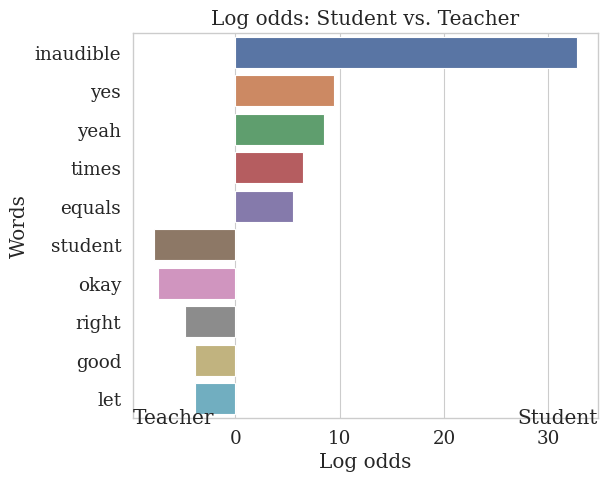

<Figure size 640x480 with 0 Axes>

In [ ]:
# This returns the merged dataframe of the annotated files in DATA_DIR.
df = lexical_analyzer.get_df()

# We want to create two groups of df: one for the student and one for the tutor.
student_df = df[df[SPEAKER_COLUMN].isin(STUDENT_SPEAKER)]
tutor_df = df[df[SPEAKER_COLUMN] == TEACHER_SPEAKER]

# Now we can run the log-odds analysis:
lexical_analyzer.plot_log_odds(
    df1=student_df,
    df2=tutor_df,
    text_column1=TEXT_COLUMN,
    text_column2=TEXT_COLUMN,
    # Let's name the df groups to show on the plot
    group1_name="Student",
    group2_name="Teacher",
    # Let's also run the text formatting
    run_text_formatting=True,
)


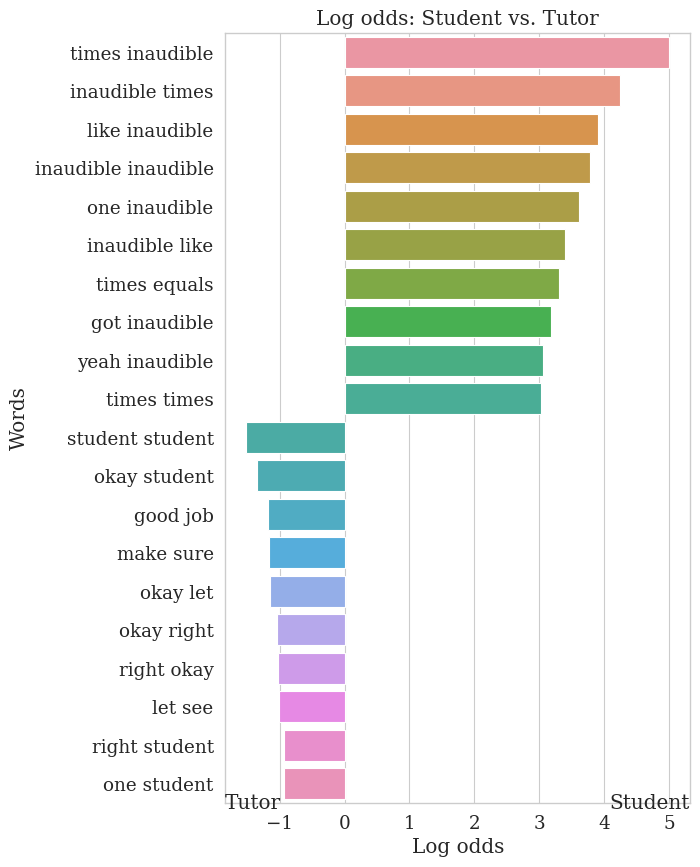

<Figure size 640x480 with 0 Axes>

In [ ]:
# We might also be interested in other n-grams. Let's look at the top 10 bigrams per speaker.
lexical_analyzer.plot_log_odds(
    df1=student_df,
    df2=tutor_df,
    text_column1=TEXT_COLUMN,
    text_column2=TEXT_COLUMN,
    group1_name="Student",
    group2_name="Tutor",
    run_text_formatting=True,
    # n-grams:
    run_ngrams=True,
    n=2,
    topk=10
)

## 📈 Temporal Analysis

Let's look at the temporal trends of the talktime, student reasoning and uptake annotations!

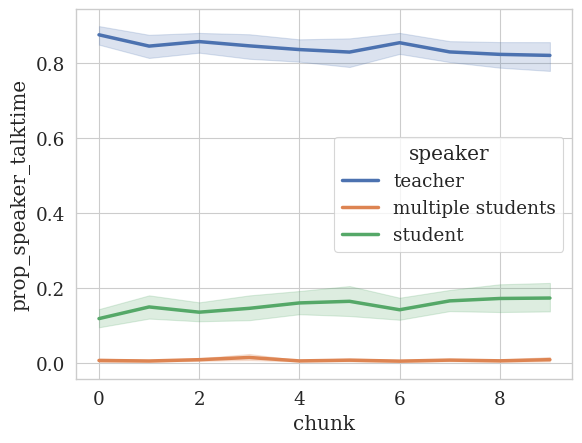

<Figure size 640x480 with 0 Axes>

In [ ]:
temporal_analyzer = TemporalAnalyzer(data_dir=ANNOTATIONS_DIR)

# First let's look at the talk time ratio between the speakers over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="prop",
    # Let's create 10 bins for the x-axis.
    num_bins=10
)

/usr/local/lib/python3.10/dist-packages/edu_convokit/analyzers/temporal_analyzer.py:57: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


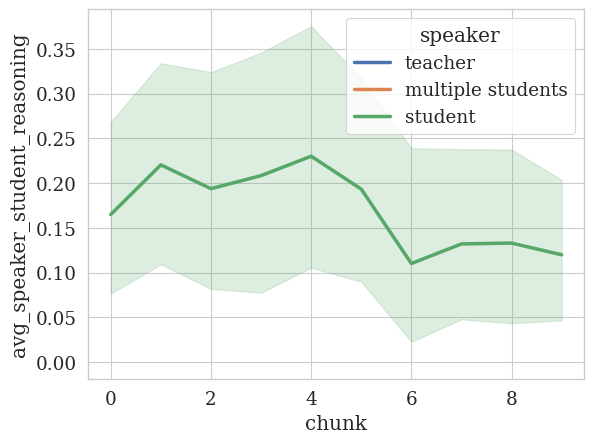

<Figure size 640x480 with 0 Axes>

In [ ]:
# Now student reasoning over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    # Let's create 5 bins for the x-axis.
    num_bins=10,
)

/usr/local/lib/python3.10/dist-packages/edu_convokit/analyzers/temporal_analyzer.py:57: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


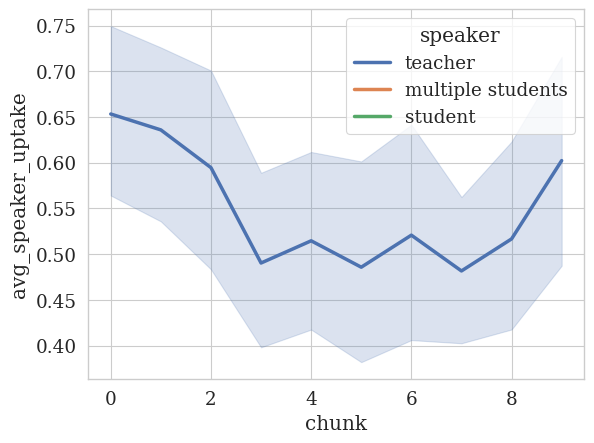

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finally, let's look at the tutor's uptake of the student's utterances over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=UPTAKE_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    # Let's create 5 bins for the x-axis.
    num_bins=10,
)

## 🤖 GPT Conversation Analysis

Finally, we can also use `edu-convokit` to analyze the conversations using GPT models. Let's use GPT4 to summarize one of the conversations.

In [1]:
import os
# Remember to never share your API key!
os.environ["OPENAI_API_KEY"]="YOUR_API_KEY"

In [ ]:
df = utils.load_data(os.path.join(DATA_DIR, "3.csv"))

# We're going to use the GPTConversationAnalyzer to summarize the conversations. 
# First, let's look at the prompt for summarization.
analyzer = GPTConversationAnalyzer()

prompt = analyzer.preview_prompt(
            df=df,
            prompt_name="summarize",
            text_column=TEXT_COLUMN,
            speaker_column=SPEAKER_COLUMN,
            model="gpt-4",
            # I'm going to only use the first quarter of the transcript
            # Because the transcript is very long
            keep_transcript_fraction=0.25,

        )
print(prompt)

💡 We can see that the prompt is set up to summarize the transcript. If you are comfortable with the prompt, you can now prompt the model on that prompt with run_prompt

In [ ]:
prompt, response = analyzer.run_prompt(
            df=df,
            prompt_name="summarize",
            text_column=TEXT_COLUMN,
            speaker_column=SPEAKER_COLUMN,
            model="gpt-4",
            keep_transcript_fraction=0.25,
        )

print(response)

## 📚 Conclusions and Next Steps

Great! From this tutorial, we learned how to use `edu-convokit` to preprocess, annotate and analyze the Amber dataset.
We saw how very simple principles built into `edu-convokit` can be used to analyze the dataset and gain insights into the data from various perspectives (qualitative, quantitative, lexical and temporal).

Other resources you can check out include:
- [Tutorial on edu-convokit for the NCTE dataset](https://colab.research.google.com/drive/1k3fn6uY4QRMtPUZN6hpMd6o-0g7fYotg)
- [Tutorial on edu-convokit for the TalkMoves dataset](https://colab.research.google.com/drive/1qt_S3GjxIwXk6ONztbYAHeX8WHy1uxDd)
- [`edu-convokit` documentation](https://edu-convokit.readthedocs.io/en/latest/index.html)
- [`edu-convokit` GitHub repository](https://github.com/rosewang2008/edu-convokit/tree/main)

If you have any questions, please feel free to reach out to us on [`edu-convokit`'s GitHub](https://github.com/rosewang2008/edu-convokit).

👋 Happy exploring your data with `edu-convokit`!